In [81]:
import torch
import torchvision
import matplotlib.pyplot as plt
from mnist import MNIST
from sklearn import manifold
import numpy as np
from time import time
from matplotlib import offsetbox

In [62]:
mndata = MNIST('Data/mnist')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

In [63]:
X_tr = np.array(train_images)
y_tr = np.array(train_labels)
X_te = np.array(test_images)
y_te = np.array(test_labels)

In [72]:
img_tr = X_tr.reshape([-1, 28,28,1])
img_te = X_te.reshape([-1, 28,28,1])

In [64]:
X_tr.shape

(60000, 784)

In [65]:
# X_tr = X_tr.reshape([-1, 28, 28])
X_tr.shape

(60000, 784)

In [79]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-2:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img_te[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing t-SNE embedding
7.95862078666687


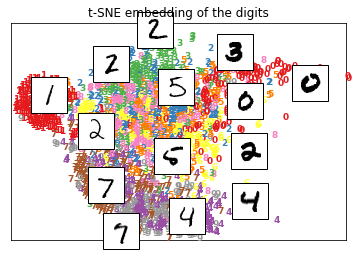

In [83]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

s = time()
X_tsne = tsne.fit_transform(X_te[:2000])
print(time() - s)

plot_embedding(X_tsne, y_te[:2000],
               "t-SNE embedding of the digits")

In [150]:
import torch.nn as nn
import torch.nn.functional as F

In [356]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d( 1,  8, 3, stride=2,padding=1) #28x28x1 -> 14x14x8
        self.conv2 = nn.Conv2d( 8, 16, 3, stride=2,padding=1) #14x14x8 -> 7x7x16
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2) #7x7x16 -> 3x3x32
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1) #3x3x32 -> 1x1x32
        self.fc1   = nn.Linear(32, 10)
        
        #Decoder
        self.t_fc1   = nn.Linear(10, 32) # [32]
        self.t_conv1 = nn.ConvTranspose2d(32, 32, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16,  8, 3, stride=2, padding=1)
        self.t_conv4 = nn.ConvTranspose2d(8,   1, 3, stride=2, output_padding=1)
    
    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))        
        x = F.relu(self.conv3(x))        
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        return x
    
    def decoder(self, x):
        x = F.relu(self.t_fc1(x)) # 10 -> 32
        x = x.reshape([-1,32,1,1])
        x = F.relu(self.t_conv1(x)) # [m, 1,1,32] -> [m, 3,3,32]
        x = F.relu(self.t_conv2(x)) # [m, 3,3,32] -> [m, 7,7,16]
        x = F.relu(self.t_conv3(x)) # [m, 7,7,16] -> 
        x = F.relu(self.t_conv4(x))
        return x                    #[m, 1, 28, 28]
    
    def forward(self, x):
        latent_vector    = self.encoder(x)
        predicted_output = self.decoder(latent_vector)
        return predicted_output
        

In [351]:
model = AutoEncoder()

In [352]:
r = torch.randn(5, 1, 28, 28)
rout = model.encoder(r)
rout.shape

torch.Size([5, 10])

In [353]:
model.decoder(rout).shape

torch.Size([5, 1, 28, 28])

In [354]:
model.forward(r).shape

torch.Size([5, 1, 28, 28])

In [355]:
print(model)

AutoEncoder(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=10, bias=True)
  (t_fc1): Linear(in_features=10, out_features=32, bias=True)
  (t_conv1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (t_conv4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
)
